In [1]:
import clip
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import cv2

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.transforms import Compose, Resize, ToTensor, Normalize

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model, _ = clip.load("RN50", device=device)

In [3]:
# In CLIP the input is resized and cropped to 224*224
# In MaskCLIP the input is resized to 512 on the short side (though the paper says 512*512)

def preprocess(n_px):
    return Compose([
        Resize(n_px),
        ToTensor(),
        Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711)),
    ])

In [4]:
# Modify the attnpool layer into MaskClipHead
# The ResNet50 model downsamples the image by 32 before the final attnpool layer

class MaskClipHead(torch.nn.Module):
    def __init__(self, clip_model):
        super().__init__()
        self.dtype = clip_model.dtype
        self.embed_dim = clip_model.visual.attnpool.q_proj.in_features
        self.output_dim = clip_model.visual.output_dim
        self.num_heads = clip_model.visual.attnpool.num_heads

        self.v_proj = nn.Conv2d(self.embed_dim, self.embed_dim, 1).to(self.dtype)
        self.c_proj = nn.Conv2d(self.embed_dim, self.output_dim, 1).to(self.dtype)

        attrs = ['v_proj', 'c_proj']
        for attr in attrs:
            state_dict = getattr(clip_model.visual.attnpool, attr).state_dict()
            for key in state_dict:
                if 'weight' in key:
                    state_dict[key] = state_dict[key][:, :, None, None]
            getattr(self, attr).load_state_dict(state_dict)
        
    def forward(self, x):
        v = self.v_proj(x)
        feat = self.c_proj(v)
        return feat

model.visual.attnpool = MaskClipHead(model).to(device)

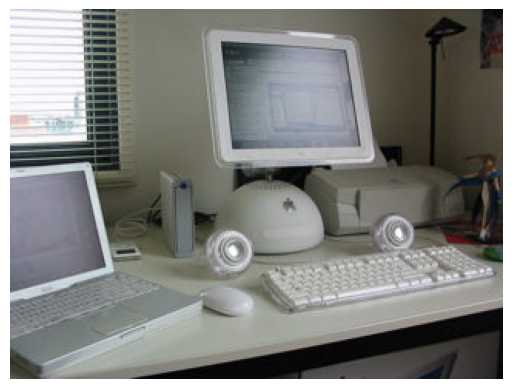

torch.Size([1, 3, 512, 682])
torch.Size([1, 1024, 16, 21])


In [5]:
image = Image.open("000000001503.jpg").convert("RGB")

plt.imshow(image)
plt.axis('off')
plt.show()

image_preprocessed = preprocess(512)(image).unsqueeze(0).to(device)
print(image_preprocessed.shape)

with torch.no_grad():
    image_features = model.encode_image(image_preprocessed)

image_features /= image_features.norm(dim=1, keepdim=True)
print(image_features.shape)

In [6]:
coco_stuff_classes = ['person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush', 'banner', 'blanket', 'branch', 'bridge', 'building', 'bush', 'cabinet', 'cage', 'cardboard', 'carpet', 'ceiling', 'tile ceiling', 'cloth', 'clothes', 'clouds', 'counter', 'cupboard', 'curtain', 'desk', 'dirt', 'door', 'fence', 'marble floor', 'floor', 'stone floor', 'tile floor', 'wood floor', 'flower', 'fog', 'food', 'fruit', 'furniture', 'grass', 'gravel', 'ground', 'hill', 'house', 'leaves', 'light', 'mat', 'metal', 'mirror', 'moss', 'mountain', 'mud', 'napkin', 'net', 'paper', 'pavement', 'pillow', 'plant', 'plastic', 'platform', 'playingfield', 'railing', 'railroad', 'river', 'road', 'rock', 'roof', 'rug', 'salad', 'sand', 'sea', 'shelf', 'sky', 'skyscraper', 'snow', 'solid', 'stairs', 'stone', 'straw', 'structural', 'table', 'tent', 'textile', 'towel', 'tree', 'vegetable', 'brick wall', 'concrete wall', 'wall', 'panel wall', 'stone wall', 'tile wall', 'wood wall', 'water', 'waterdrops', 'blind window', 'window', 'wood']

prompt_templates = [
    'a bad photo of a {}.', 'a photo of many {}.', 'a sculpture of a {}.', 'a photo of the hard to see {}.', 'a low resolution photo of the {}.', 'a rendering of a {}.', 'graffiti of a {}.', 'a bad photo of the {}.', 'a cropped photo of the {}.', 'a tattoo of a {}.', 'the embroidered {}.', 'a photo of a hard to see {}.', 'a bright photo of a {}.', 'a photo of a clean {}.', 'a photo of a dirty {}.', 'a dark photo of the {}.', 'a drawing of a {}.', 'a photo of my {}.', 'the plastic {}.', 'a photo of the cool {}.', 'a close-up photo of a {}.', 'a black and white photo of the {}.', 'a painting of the {}.', 'a painting of a {}.', 'a pixelated photo of the {}.', 'a sculpture of the {}.', 'a bright photo of the {}.', 'a cropped photo of a {}.', 'a plastic {}.', 'a photo of the dirty {}.', 'a jpeg corrupted photo of a {}.', 'a blurry photo of the {}.', 'a photo of the {}.', 'a good photo of the {}.', 'a rendering of the {}.', 'a {} in a video game.', 'a photo of one {}.', 'a doodle of a {}.', 'a close-up photo of the {}.', 'a photo of a {}.', 'the origami {}.', 'the {} in a video game.', 'a sketch of a {}.', 'a doodle of the {}.', 'a origami {}.', 'a low resolution photo of a {}.', 'the toy {}.', 'a rendition of the {}.', 'a photo of the clean {}.', 'a photo of a large {}.', 'a rendition of a {}.', 'a photo of a nice {}.', 'a photo of a weird {}.', 'a blurry photo of a {}.', 'a cartoon {}.', 'art of a {}.', 'a sketch of the {}.', 'a embroidered {}.', 'a pixelated photo of a {}.', 'itap of the {}.', 'a jpeg corrupted photo of the {}.', 'a good photo of a {}.', 'a plushie {}.', 'a photo of the nice {}.', 'a photo of the small {}.', 'a photo of the weird {}.', 'the cartoon {}.', 'art of the {}.', 'a drawing of the {}.', 'a photo of the large {}.', 'a black and white photo of a {}.', 'the plushie {}.', 'a dark photo of a {}.', 'itap of a {}.', 'graffiti of the {}.', 'a toy {}.', 'itap of my {}.', 'a photo of a cool {}.', 'a photo of a small {}.', 'a tattoo of the {}.', 'there is a {} in the scene.', 'there is the {} in the scene.', 'this is a {} in the scene.', 'this is the {} in the scene.', 'this is one {} in the scene.',
]

with torch.no_grad():
    classifier_weights = []
    for class_name in coco_stuff_classes:
        texts = [template.format(class_name) for template in prompt_templates]
        text = clip.tokenize(texts).to(device)
        text_features = model.encode_text(text)
        text_features /= text_features.norm(dim=-1, keepdim=True)
        text_features = text_features.mean(dim=0)
        text_features /= text_features.norm()
        classifier_weights.append(text_features)
    classifier_weights = torch.stack(classifier_weights)

print(classifier_weights.shape)

torch.Size([171, 1024])


In [7]:
logits = F.conv2d(image_features, classifier_weights[:, :, None, None]).squeeze()

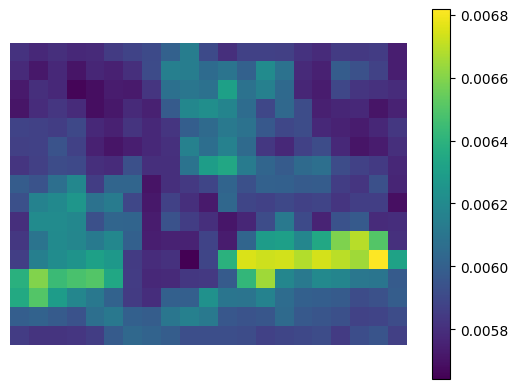

In [8]:
# Confidence map for the keyboard class

probs = logits.softmax(dim=0)
probs_keyboard = probs[66]

plt.imshow(probs_keyboard.cpu().numpy())
plt.axis('off')
plt.colorbar()
plt.show()

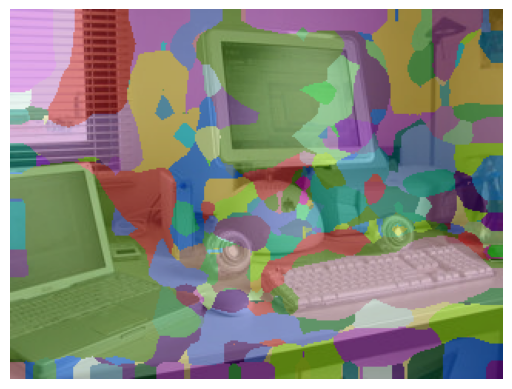

In [9]:
# Interpolate to pixel-level and visualize
# Not exactly matching MaskCLIP's output
# Possible discrepancies include normalization, interpolation, etc.

image_np = np.array(image)

logits_resized = F.interpolate(
    logits.unsqueeze(0),
    size=image_np.shape[:2],
    mode='bilinear',
    align_corners=False,
).squeeze(0)

pred_classes = torch.argmax(logits_resized, dim=0).cpu()

C = logits.shape[0]
colors = np.random.randint(0, 255, size=(C, 3), dtype=np.uint8)
mask = np.zeros_like(image_np)

for i in range(C):
    mask[pred_classes == i] = colors[i]

mask = cv2.addWeighted(image_np, 0.5, mask, 0.5, 0)

plt.imshow(mask)
plt.axis('off')
plt.show()